# Exploratory Data Analysis

## 1. Load the Data

In [42]:
import pandas as pd

dataset_df = pd.read_csv('data/combined_scam_dataset.csv')

In [43]:
dataset_df.head()

,dialogue,labels,type
0,"caller: hi, this is karen from dr. smith's off...",0,appointment
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment


In [44]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dialogue  5820 non-null   object
 1   labels    5820 non-null   int64 
 2   type      5820 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.5+ KB


In [45]:
dataset_df['labels'].value_counts()

labels
1    2944
0    2876
Name: count, dtype: int64

## 2. Explore the data

This process is important as we will need to understand our data before we can further apply machine learning models to it. Some of our key analyses include:

1. Performing EDA separately for the "Caller" and the "Recipient";
2. Identify the differences in language usage between the two roles;
3. Perform data visualization such as **word clouds** to identify frequently used words for both "Caller" and "Recipient";
4. Plot top unigrams, bigrams, and trigrams for each speaker category;
    - Purpose: To gain insights onto conversational patterns
    - Can identify the frequency of scam-specific words/phrases such as "SSN" or "Congratulations" or "Claim Prize"


### Remove stopwords from the text

In [46]:
from nltk.corpus import stopwords

def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [47]:
dataset_df['dialogue_processed'] = dataset_df['dialogue'].apply(remove_stopwords)

In [48]:
dataset_df.head()

,dialogue,labels,type,dialogue_processed
0,"caller: hi, this is karen from dr. smith's off...",0,appointment,"caller: hi, karen dr. smith's office. i'm call..."
1,"caller: hi, is this john? recipient: yeah, tha...",0,appointment,"caller: hi, john? recipient: yeah, that's me. ..."
2,"caller: hi, i'm calling from xyz medical cente...",0,appointment,"caller: hi, i'm calling xyz medical center. sc..."
3,"caller: hi, i'm calling to confirm your appoin...",0,appointment,"caller: hi, i'm calling confirm appointment to..."
4,"caller: hi, i'm calling from dr. smith's offic...",0,appointment,"caller: hi, i'm calling dr. smith's office. sc..."


### Separate Caller and Recipient Conversation

In [49]:
import pandas as pd

def extract_caller_and_recipient_texts(dataframe, dialogue_column):
    """
    Extracts texts spoken by 'caller' and 'recipient' from the dialogue column.
    
    Args:
        dataframe (pd.DataFrame): The input dataframe.
        dialogue_column (str): The name of the column with dialogues.
    
    Returns:
        pd.Series, pd.Series: Two Series containing caller and recipient texts.
    """
    caller_texts = []
    recipient_texts = []
    
    for dialogue in dataframe[dialogue_column]:
        # Initialize empty caller and recipient texts
        caller_text = []
        recipient_text = []

        # Split the dialogue into parts based on markers
        parts = dialogue.split("caller:")
        for part in parts[1:]:  # Skip the first split (everything before the first 'caller:')
            if "recipient:" in part:
                # Split between caller and recipient
                caller, recipient = part.split("recipient:", 1)
                caller_text.append(caller.strip())
                recipient_text.append(recipient.strip())
            else:
                # No recipient part, only caller's text
                caller_text.append(part.strip())

        # Append the extracted text to respective lists
        caller_texts.append(" ".join(caller_text))
        recipient_texts.append(" ".join(recipient_text))
    
    # Convert to pandas Series
    return pd.Series(caller_texts, name="caller_texts"), pd.Series(recipient_texts, name="recipient_texts")

In [50]:
caller_texts, recipient_texts = extract_caller_and_recipient_texts(dataset_df, "dialogue")

dataset_df["caller_texts"] = caller_texts
dataset_df["recipient_texts"] = recipient_texts

#### Caller Texts

In [51]:
dataset_df['caller_texts'].head()

0    hi, this is karen from dr. smith's office. i'm...
1    hi, is this john? this is karen from dr. smith...
2    hi, i'm calling from xyz medical center. we ha...
3    hi, i'm calling to confirm your appointment fo...
4    hi, i'm calling from dr. smith's office. we ha...
Name: caller_texts, dtype: object

In [52]:
dataset_df['caller_texts'].tail()

5815    hi, how are you doing today? i'm doing fine. i...
5816    hello there, how's your day going? i'm doing f...
5817    hey, how's it going? i'm doing fine. i've been...
5818    hi there, how's your day going? i'm doing fine...
5819    hello, how's your day going? i'm doing fine. i...
Name: caller_texts, dtype: object

#### Recipient Texts

In [53]:
dataset_df['recipient_texts'].head()

0    oh, hi karen. i think there might be some mist...
1    yeah, that's me. who's this? ah, yeah. i think...
2    actually, i'm not sure. can you tell me what t...
3    oh, i don't recall scheduling an appointment. ...
4    actually, i don't recall making an appointment...
Name: recipient_texts, dtype: object

In [54]:
dataset_df['recipient_texts'].tail()

5815    i'm doing well, thank you. just came back from...
5816    it's been great, thanks. just went to a dance ...
5817    it's been great, thanks. just went to a wine t...
5818    it's been great, thanks. just went to a potter...
5819    it's been great, thanks. just went to a garden...
Name: recipient_texts, dtype: object

### Word Cloud

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text_series, title):
    """
    Generates a word cloud from a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        title (str): Title of the word cloud visualization.
    """
    text = " ".join(text_series.dropna())  # Combine all text into one string
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

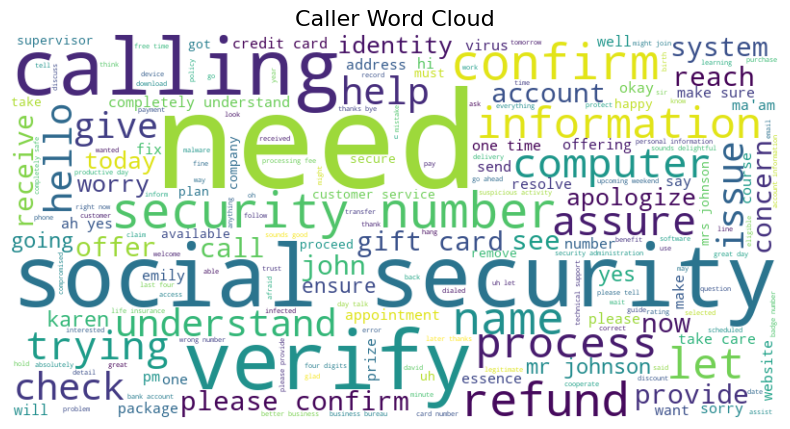

In [56]:
generate_word_cloud(dataset_df["caller_texts"], "Caller Word Cloud")

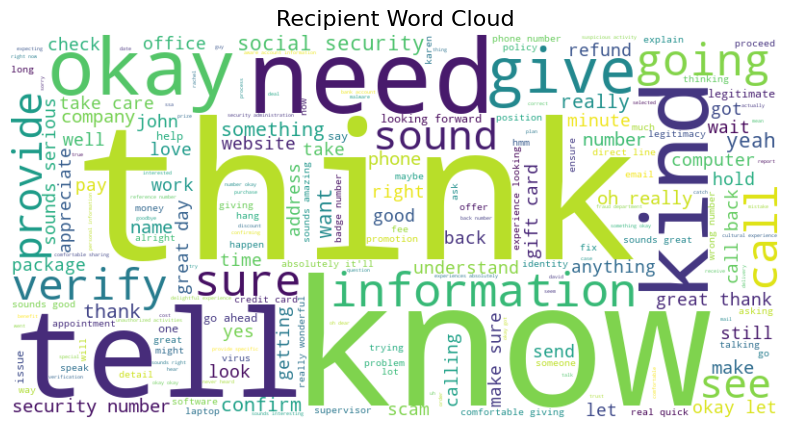

In [57]:
generate_word_cloud(dataset_df["recipient_texts"], "Recipient Word Cloud")

### Most frequently used words for both caller and recipient (Unigram)

The N-gram, is a measure of a sequence of tokens. For example, a 1-gram or unigram is a sequence containing 1 token.

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(text_series, top_k=10):
    """
    Identifies the most frequently used words in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        top_k (int): Number of top words to extract.
    
    Returns:
        List of tuples: Top words and their counts.
    """
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(text_series.dropna())
    word_freq = word_counts.sum(axis=0).A1
    word_features = vectorizer.get_feature_names_out()
    top_words = sorted(zip(word_features, word_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_words

In [59]:
import matplotlib.pyplot as plt

def plot_top_words(word_freq, title):
    """
    Plots the top words with their frequencies as a bar chart.
    
    Args:
        word_freq (list of tuples): List of words and their counts.
        title (str): Title of the plot.
    """
    words, counts = zip(*word_freq)  # Unpack words and counts
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color="skyblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Words", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

#### Top Caller Words

In [60]:
top_caller_words = get_top_words(dataset_df["caller_texts"], top_k=10)
print("Top Caller Words:", top_caller_words)

Top Caller Words: [('you', np.int64(50392)), ('to', np.int64(42350)), ('the', np.int64(32172)), ('your', np.int64(28584)), ('and', np.int64(27786)), ('we', np.int64(22173)), ('it', np.int64(17078)), ('is', np.int64(16429)), ('can', np.int64(15845)), ('that', np.int64(14053))]


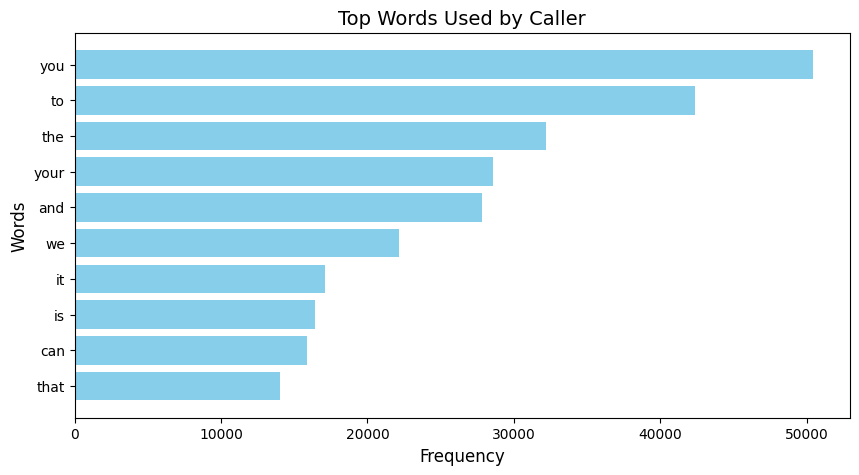

In [61]:
plot_top_words(top_caller_words, "Top Words Used by Caller")

#### Top Recipient Words

In [62]:
top_recipient_words = get_top_words(dataset_df["recipient_texts"], top_k=10)
print("Top Recipient Words:", top_recipient_words)

Top Recipient Words: [('you', np.int64(30002)), ('to', np.int64(18524)), ('the', np.int64(15515)), ('that', np.int64(14800)), ('can', np.int64(14279)), ('me', np.int64(11969)), ('it', np.int64(11378)), ('what', np.int64(11168)), ('and', np.int64(10210)), ('my', np.int64(8957))]


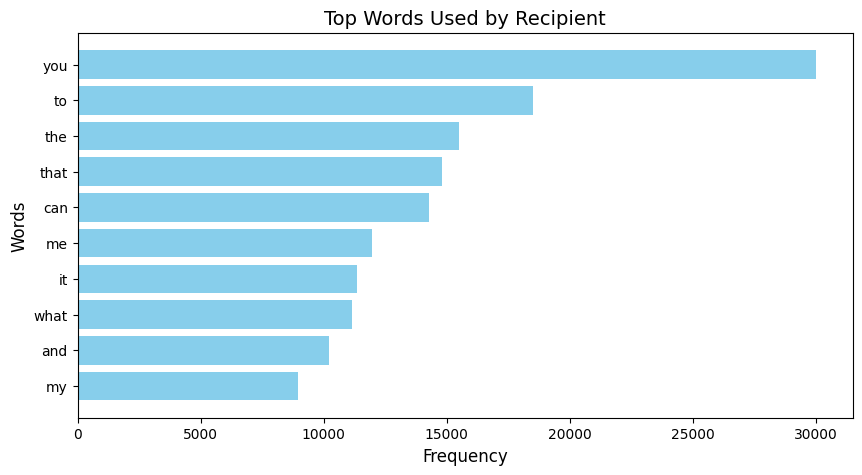

In [63]:
plot_top_words(top_recipient_words, "Top Words Used by Recipient")

### Most frequent bi-grams and tri-grams

This focuses on phrase-level granularity

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Function to get top n-grams
def get_top_ngrams(text_series, n, top_k=10):
    """
    Identifies the most frequently used n-grams in a series of text data.
    
    Args:
        text_series (pd.Series): Series containing text data.
        n (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
        top_k (int): Number of top n-grams to extract.
    
    Returns:
        List of tuples: Top n-grams and their counts.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_counts = vectorizer.fit_transform(text_series.dropna())
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    top_ngrams = sorted(zip(ngram_features, ngram_freq), key=lambda x: x[1], reverse=True)[:top_k]
    return top_ngrams

# Function to plot n-grams
def plot_top_ngrams(ngrams, title):
    """
    Plots the top n-grams with their frequencies as a bar chart.
    
    Args:
        ngrams (list of tuples): List of n-grams and their counts.
        title (str): Title of the plot.
    """
    ngram_labels, ngram_counts = zip(*ngrams)  # Unpack n-grams and counts
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color="lightblue")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("N-Grams", fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.show()

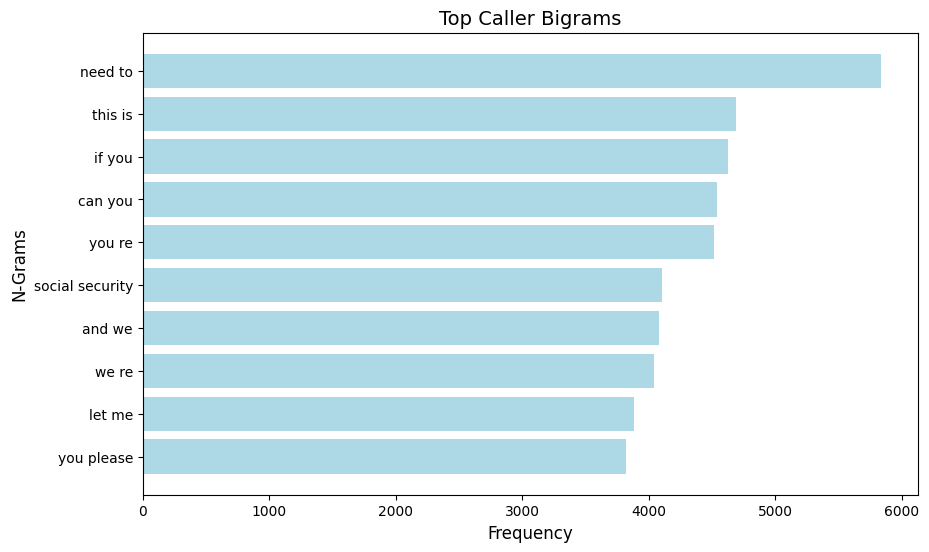

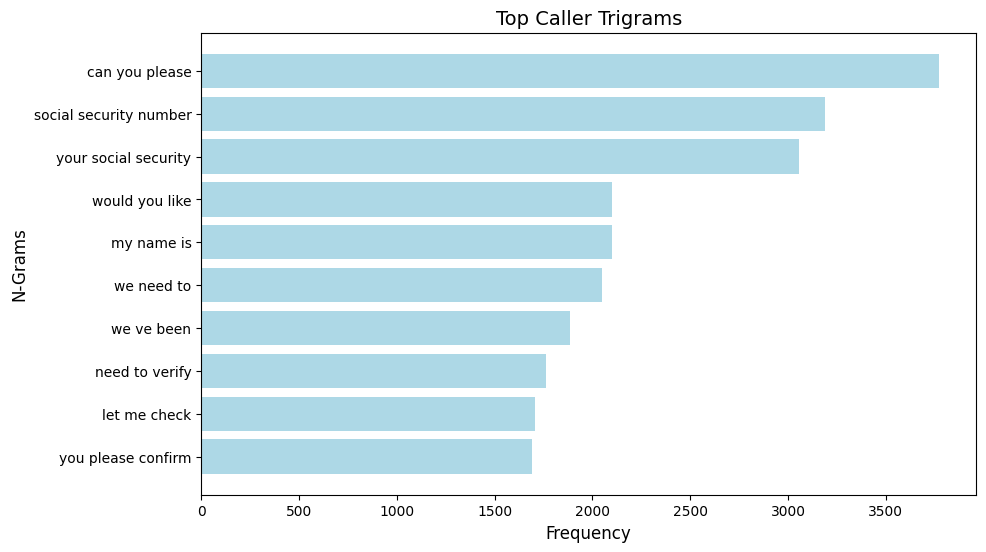

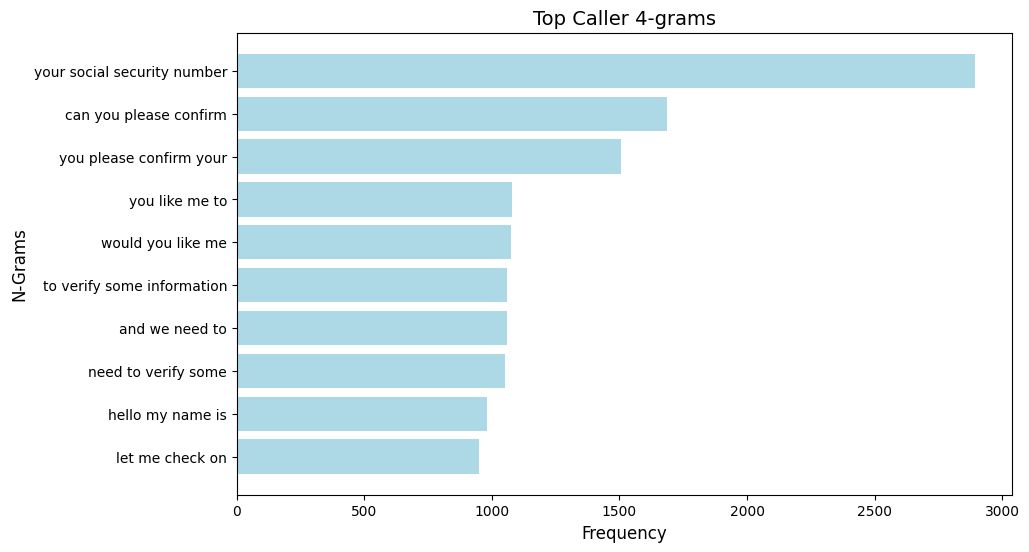

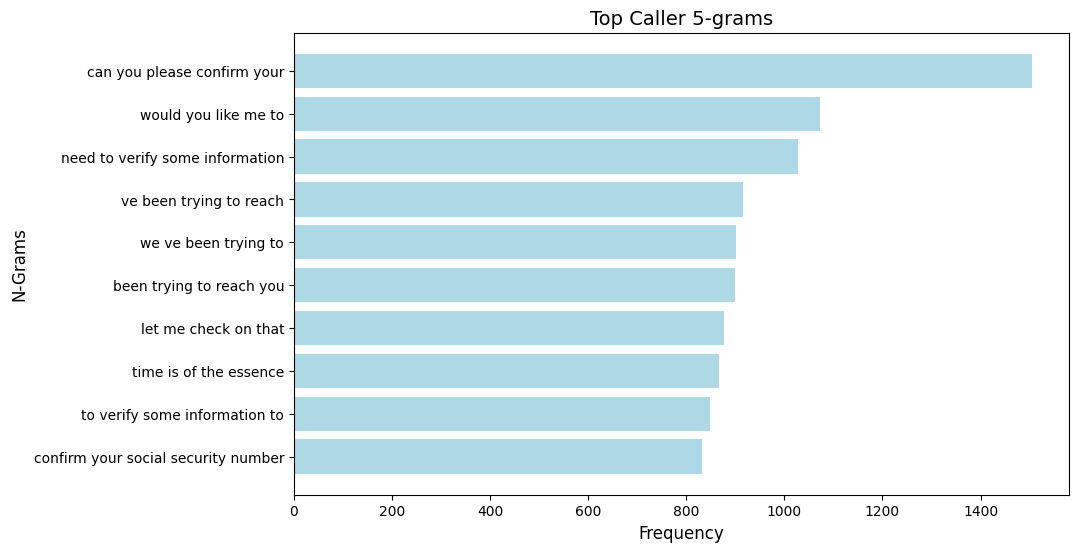

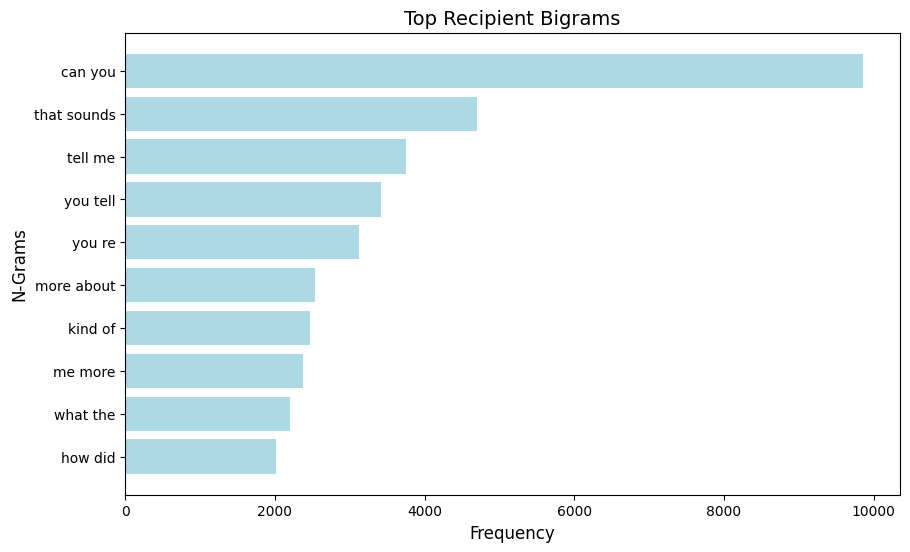

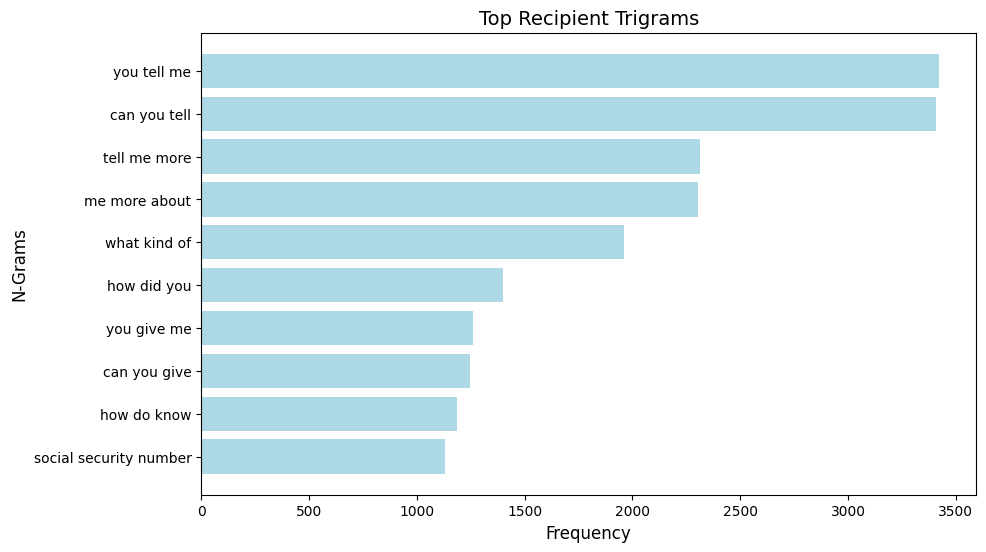

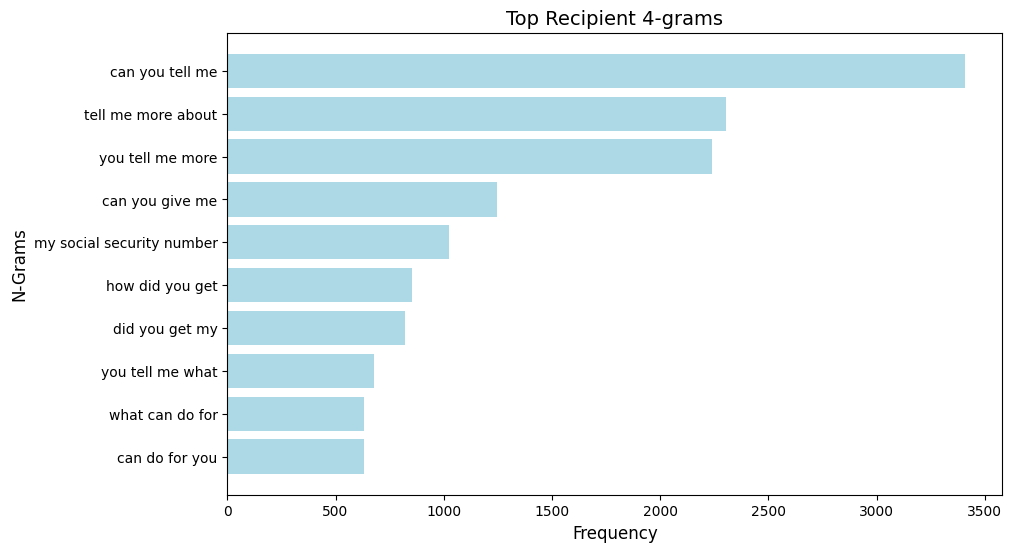

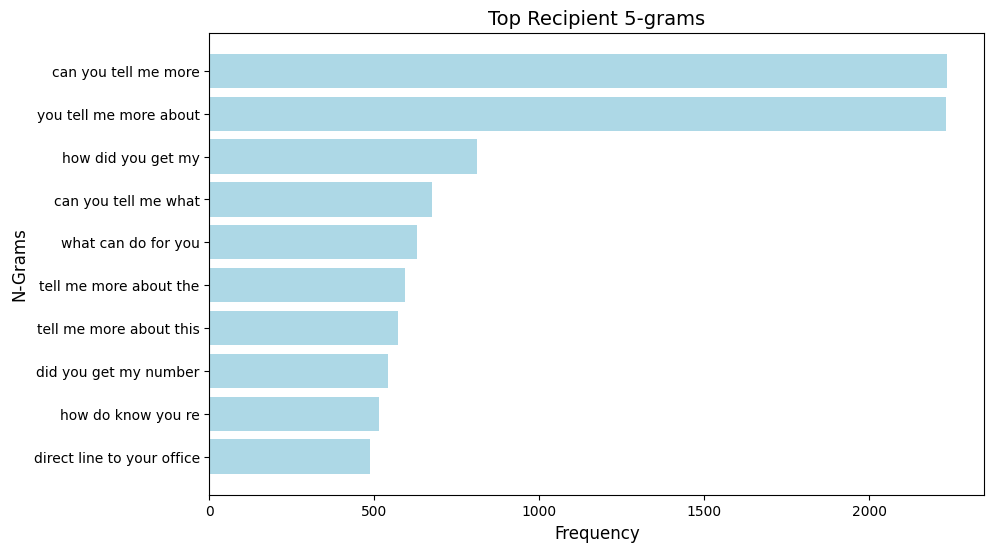

In [67]:
# Replace with your dataset's caller and recipient texts
caller_texts = dataset_df["caller_texts"]  # Ensure this contains the extracted caller texts
recipient_texts = dataset_df["recipient_texts"]  # Ensure this contains the extracted recipient texts

# Generate Bigrams and Trigrams
top_caller_bigrams = get_top_ngrams(caller_texts, n=2, top_k=10)
top_caller_trigrams = get_top_ngrams(caller_texts, n=3, top_k=10)
top_caller_4grams = get_top_ngrams(caller_texts, n=4, top_k=10)
top_caller_pentagrams = get_top_ngrams(caller_texts, n=5, top_k=10)

top_recipient_bigrams = get_top_ngrams(recipient_texts, n=2, top_k=10)
top_recipient_trigrams = get_top_ngrams(recipient_texts, n=3, top_k=10)
top_recipient_4grams = get_top_ngrams(recipient_texts, n=4, top_k=10)
top_recipient_pentagrams = get_top_ngrams(recipient_texts, n=5, top_k=10)

# Plot Bigrams and Trigrams for Caller and Recipient
plot_top_ngrams(top_caller_bigrams, "Top Caller Bigrams")
plot_top_ngrams(top_caller_trigrams, "Top Caller Trigrams")
plot_top_ngrams(top_caller_4grams, "Top Caller 4-grams")
plot_top_ngrams(top_caller_pentagrams, "Top Caller 5-grams")
plot_top_ngrams(top_recipient_bigrams, "Top Recipient Bigrams")
plot_top_ngrams(top_recipient_trigrams, "Top Recipient Trigrams")
plot_top_ngrams(top_recipient_4grams, "Top Recipient 4-grams")
plot_top_ngrams(top_recipient_pentagrams, "Top Recipient 5-grams")

You can definitely tell the difference in N-grams between the callers and recipients based on the bar charts above.